# Data Analysis

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from pathlib import Path
pathtohere = Path.cwd()
print(pathtohere)

C:\Users\02dba\Documents\GitHub\Diatomic-Molecule-Dissociation-by-Gravitational-Gradient\contents


<IPython.core.display.Javascript object>


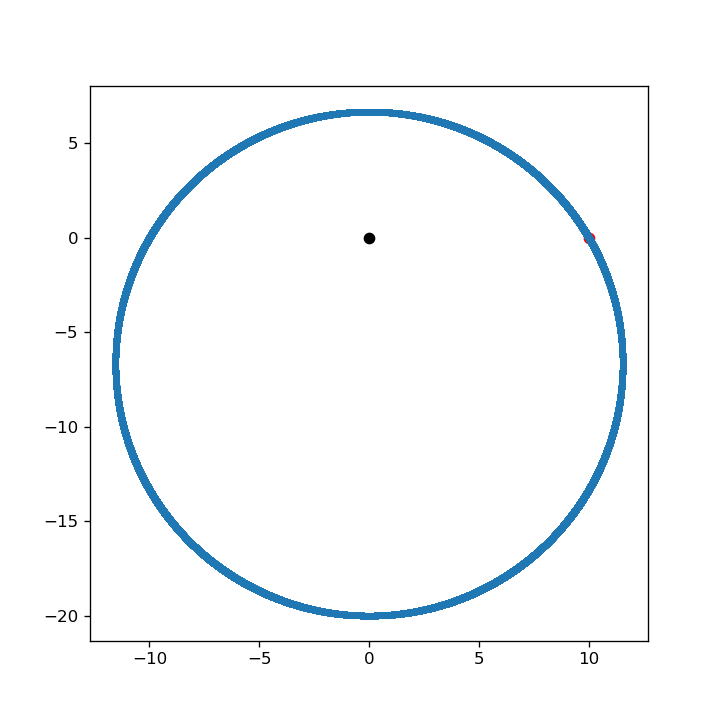

[10.          9.995       9.99000001  9.98500002  9.98000005]


In [2]:
numSteps = int(1e+5)
L = 1e+1
M = 1e+1

rs = np.zeros(numSteps)
phis = np.zeros_like(rs)
phis[0] = 0.
rs[0] = 10.
dt = 1e-2
r_dot = -5e-1

rs[1] = rs[0] + dt*r_dot + dt*dt*(L*L/(rs[0]*rs[0]*rs[0]) - M/(rs[0]*rs[0]))


# Set r_dot = 0 by energy.
energy = 0.5* (r_dot*r_dot + L*L/(rs[0]*rs[0])) - M/rs[0]




for step in range(1,numSteps-1):
    rs[step+1] = 2*rs[step] - rs[step-1] + dt*dt*(L*L/(rs[step]*rs[step]*rs[step]) - M/(rs[step]*rs[step]))


    phis[step+1] = phis[step] + dt*L/(rs[step]*rs[step])
    
    
   
    
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

ax.scatter(0,0,c='k')
ax.scatter(rs[0]*np.cos(phis[0]), rs[0]*np.sin(phis[0]), c='r', marker='o')
ax.plot(rs*np.cos(phis), rs*np.sin(phis), marker='.')


plt.show()


print(rs[:5])

In [3]:
epsilon_0 = 8.85e-12

In [4]:
class BlackHole:
    mass = 0.
    a = 0.
    l = 0.
    charge = 0.
    
class Particle:
    mass = 0.
    charge = 0. # electric charge
    energy = 0.
    L = 0. # angular momentum


def readPropertiesFile():
    """
    Read the properties file and save the variables.
    """
    
    BH = BlackHole()
    particle = Particle()
    
    isPlaner = False
    
    line = True
    filePath = pathtohere / 'data/properties.txt'
    i = 0
    maxFileSize = 1_000
    # https://stackoverflow.com/questions/3277503/how-to-read-a-file-line-by-line-into-a-list
    with open(filePath, 'r', encoding='UTF-8') as f:
        while line and i < maxFileSize:
            line = f.readline()
            
            if (line[:-1] == "# moleculeLength [double]"):
                line = f.readline()
                i += 1
                moleculeLength = float(line)
            elif (line[:-1] == "# numParticles [unsigned int]"):
                line = f.readline()
                i += 1
                numParticles = int(line)

            # TODO: This part will need to be changed for multiple particles at a later date.
            elif (line[:-1] == "# particle masses (delimit by commas) [double]"):
                line = f.readline()
                i += 1;
                particle.mass = float(line)
            elif (line[:-1] == "# particle electric charges (delimit by commas) [double]"):
                line = f.readline()
                i += 1
                particle.charge = float(line)
            elif (line[:-1] == "# particle energies (delimit by commas) [double]"):
                line = f.readline()
                i += 1
                if line[:-1]=='planer':
                    isPlaner=True
                    continue
                particle.energy = float(line)
            elif (line[:-1] == "# particle angular momenta (delimit by commas) [double]"):
                line = f.readline()
                i += 1
                particle.L = float(line)
            elif (line[:-1] == "# particle start times (delimit by commas) [double]"):
                line = f.readline()
                i += 1
                startTime1 = float(line)
            elif (line[:-1] == "# particle start radii (delimit by commas) [double]"):
                line = f.readline()
                i += 1
                startRadius1 = float(line)
            elif (line[:-1] == "# particle start phis (delimit by commas) [double]"):
                line = f.readline()
                i += 1
                startPhi1 = float(line)
            elif (line[:-1] == "# particle start thetas (delimit by commas) [double]"):
                line = f.readline()
                i += 1
                startTheta1 = float(line)

            # Black hole properties
            elif (line[:-1] == "# Black hole mass [double]"):
                line = f.readline()
                i += 1
                BH.mass = float(line)
            elif (line[:-1] == "# Black hole angular momentum to mass ratio-ish (a) [double]"):
                line = f.readline()
                i += 1
                BH.a = float(line)
            elif (line[:-1] == "# Black hole gravitomagnetic monopole moment (l) [double]"):
                line = f.readline()
                i += 1
                BH.l = float(line)
            elif (line[:-1] == "# Black hole electric charge (Q) [double]"):
                line = f.readline()
                i += 1
                BH.charge = float(line)

            elif (line == "\n" or line==''):
                continue
            else:
                raise Exception("Unrecognised line in properties file:",line)
            
            
            i += 1

            if i >= maxFileSize:
                raise Exception(f'Unsafe file size: number of lines exceeds {maxFileSize}.')
                
    if isPlaner:
        particle.energy = (particle.L / (2. * BH.a)
                + 0.5 * np.sqrt(particle.L * particle.L / (BH.a * BH.a) 
                    + 2. * particle.mass * particle.mass))
                
    return BH, particle

In [5]:
def displaySystem(BH, coords:np.ndarray):
    """
    Display the particle(')s(') motion through the system.
    
    Inputs:
        - BH: Instance of the black hole.
        - coords:np.ndarray: History of the coordinates of all the particles.
    """
    
    r_Q2 = BH.charge*BH.charge / (4*np.pi*epsilon_0)
    r_s = 2.*BH.mass
    
    fig = plt.figure(figsize=(6,6), dpi=150)
    ax = fig.add_subplot(111, projection='3d')
    
    # Sphere mesh.
    phi = np.linspace(0, 2 * np.pi, 100)
    theta = np.linspace(0, np.pi, 100)
    x = np.cos(phi)[:, None] * np.sin(theta)[None,:]
    y = np.sin(phi)[:,None] * np.sin(theta)[None,:]
    z = np.ones(np.size(phi))[:,None] * np.cos(theta)[None,:]
    
    # Inner horizon
    r = r_s / 2. - np.sqrt(r_s*r_s / 4. - BH.a*BH.a - r_Q2)
    ax.plot_surface(r * x, r * y, r * z, color='black', alpha=0.3)
    print(f'Inner horizon: {r}')
    # Outer horizon
    r = r_s / 2. + np.sqrt(r_s*r_s / 4. - BH.a*BH.a - r_Q2)
    ax.plot_surface(r * x, r * y, r * z, color='m', alpha=0.3)
    print(f'Outer horizon: {r}')
    
    # Inner ergosphere
    r = r_s / 2. - np.sqrt(r_s*r_s / 4. - BH.a*BH.a*np.cos(theta)*np.cos(theta) - r_Q2)
    ax.plot_surface(r[None,:] * x, r[None,:] * y, r[None,:] * z, color='cyan', alpha=0.3)
    print(f'Inner ergosphere: [{r.min()},{r.max()}]')
    # Outer ergosphere
    r = r_s / 2. + np.sqrt(r_s*r_s / 4. - BH.a*BH.a*np.cos(theta)*np.cos(theta) - r_Q2)
    ax.plot_surface(r[None,:] * x, r[None,:] * y, r[None,:] * z, color='yellow', alpha=0.3)
    print(f'Outer ergosphere: [{r.min()},{r.max()}]')
    
    # Particle trajectory.
    x = coords[:,1] * np.sin(coords[:,3]) * np.cos(coords[:,2])
    y = coords[:,1] * np.sin(coords[:,3]) * np.sin(coords[:,2])
    z = coords[:,1] * np.cos(coords[:,3])
    ax.plot(x,y,z, c='b')
    
    
    # Create appropiate labels.
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    # Limit graph size.
    size = 11.
    ax.set_xlim(-size, size)
    ax.set_ylim(-size, size)
    ax.set_zlim(-size, size)
    
    plt.show()
    
    
    

In [6]:
def main():
    
    BH, particle1 = readPropertiesFile()
    particleCoords = np.loadtxt(pathtohere / 'data/coords.txt', delimiter=',', dtype=float)

    
    
    
    print(particleCoords.shape)
    displaySystem(BH, particleCoords)
    

(100000, 4)


<IPython.core.display.Javascript object>


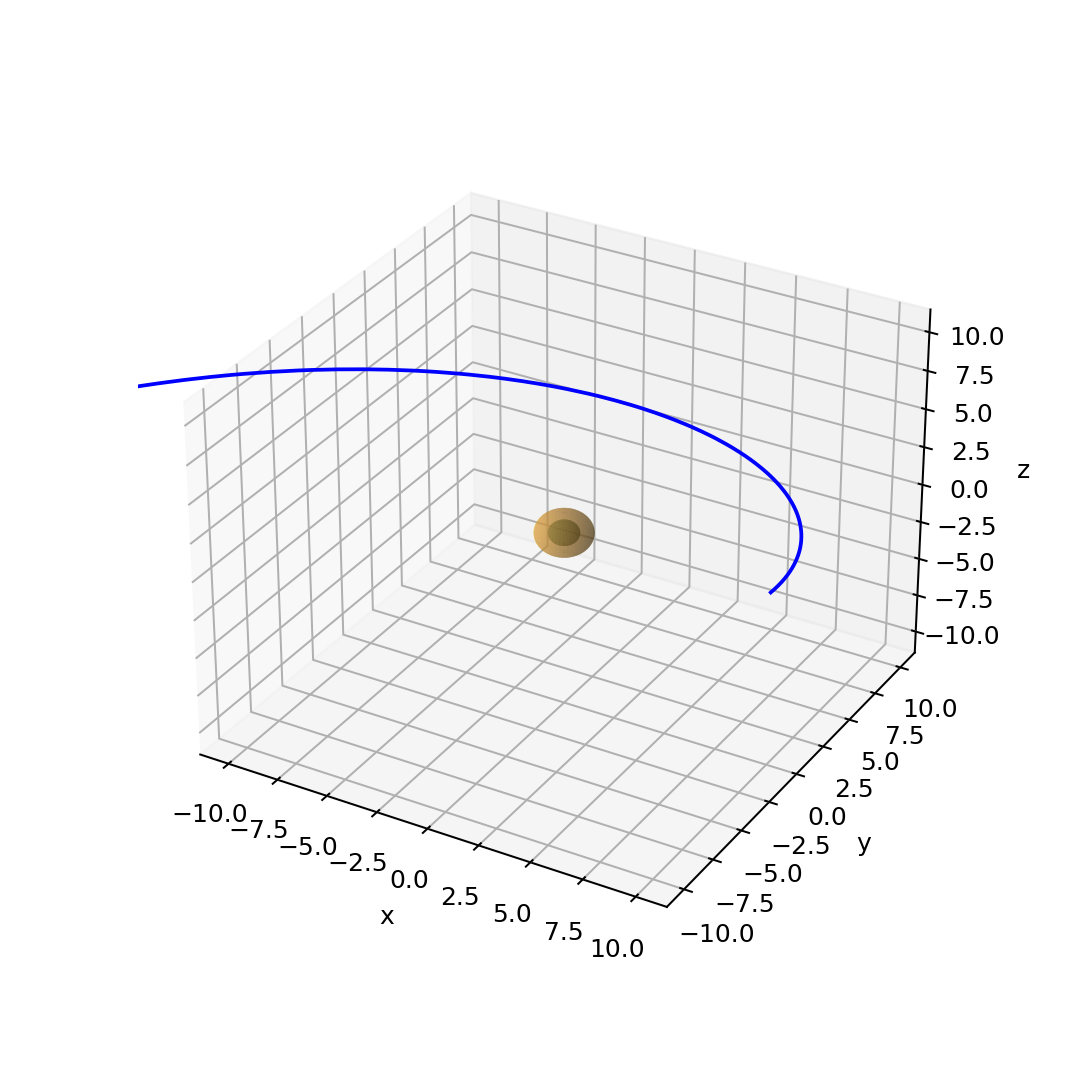

Inner horizon: 0.6986372110656933
Outer horizon: 1.3013627889343067
Inner ergosphere: [0.6824830504269427,0.6986372110656933]
Outer ergosphere: [1.3013627889343067,1.3175169495730574]


In [7]:
if __name__=='__main__':
    main()